In [1]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from omegaconf import DictConfig
from torch.utils.data import DataLoader

import torch
import torchmetrics
import torch.nn.functional as F
import tqdm
import pytorch_lightning as pl
import numpy as np

from dataset.cub import CUB200
from model.vit import VisionTransformer
from pl_model.vit import LitViT

In [2]:
config = DictConfig({
    "model": "vit",
    "save_path": "/home/lorenzo/xfg/pretrained/vit",
    "patch_size": 32,
    "split": "overlap",
    "slide_step": 24,
    "hidden_size": 768,
    "dropout": 0.1,
    "max_len": 49,
    "classifier": "token",
    "num_classes": 200,
    "batch_size": 16,
    "num_workers": 16,
    "image_size": 448,
    "transformer": {
        "mlp_dim": 3072,
        "num_heads": 12,
        "num_layers": 12,
        "attention_dropout_rate": 0.0,
    },
    "lr": 1e-2,
    "seed": 42,
    "momentum": 0.9,
    "epoch": 100,
    "gpus": 2,
    "logger": True,
    "patience": 10,
    "pretrained_dir": "/home/lorenzo/xfg/pretrained/vit/imagenet21k_ViT-B_32.npz",
    "root": "/home/lorenzo/xfg/data",
    "warmup": False,
    "project": "xfg",
})

In [3]:
test_transform=transforms.Compose([
    transforms.Resize((600, 600), InterpolationMode.BILINEAR),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set = CUB200(root="./data", train=False, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=16,
                        pin_memory=True, num_workers=8)


In [4]:
model = LitViT.load_from_checkpoint(os.path.join("/home/lorenzo/xfg/outputs/2021-06-06/20-42-14/wandb/latest-run/files/xfg/1b8ggjzv/checkpoints", "epoch=15-step=5999.ckpt"), config=config)
model = model.model
model.to("cuda:0")
# torch.save(model.model.state_dict(), os.path.join(config.save_path, "vit_cub.pt"))

test_accuracy = torchmetrics.Accuracy()
test_accuracy = test_accuracy.to("cuda:0")

preds = []
outs = []
for inputs, targets in tqdm.tqdm(test_loader):
    inputs = inputs.to("cuda:0")
    targets = targets.to("cuda:0")

    outputs, attn_weights = model(inputs)

    loss = F.cross_entropy(outputs.view(-1, config.num_classes), targets.view(-1))
    preds.append(torch.argmax(outputs, dim=-1))
    outs.append(targets)
    test_acc = test_accuracy(torch.argmax(outputs, dim=-1), targets)

load_pretrained: grid-size from 7 to 18
100%|██████████| 363/363 [00:43<00:00,  8.36it/s]


In [ ]:
test_accuracy.compute()

In [11]:
pred = torch.cat(preds, dim=0).cpu().detach().numpy()
out = torch.cat(outs, dim=0).cpu().detach().numpy()

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(pred, out)

0.8688298239558163

In [38]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

index = list(dict([(int(v), k.split(".")[-1]) for k, v in test_set.class_idx.items()]).values())
conf_df = pd.DataFrame(confusion_matrix(out, pred, labels=list(range(1, 201)), normalize="true"))
conf_df.index = index
conf_df.columns = index

<AxesSubplot:>

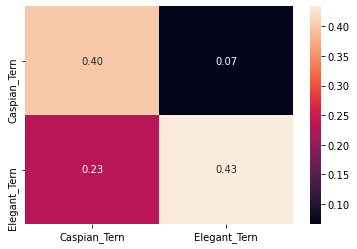

In [43]:
sns.heatmap(conf_df.iloc[[142,144],[142,144]], annot=True, fmt=".2f")